In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

In [16]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128

In [17]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [18]:
def generate_beta(timesteps, beta_start=0.0001, beta_end=0.02):
    betas = torch.linspace(beta_start, beta_end, timesteps)
    return betas

def get_index(vals, timestep, x_shape):
    batch_size = timestep.shape[0]
    out = vals.gather(-1,timestep.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(timestep.device)

def forward_diffusion(x_0, timestep, device="cpu"):
    noise = torch.randn_like(x_0)
    alpha_bar1_t = get_index(alpha_bar1, timestep, x_0.shape)
    alpha_bar2_t = get_index(alpha_bar2, timestep, x_0.shape)
    return alpha_bar1_t.to(device) * x_0.to(device) \
    + alpha_bar2_t.to(device) * noise.to(device), noise.to(device)

In [ ]:
T = 200
betas = generate_beta(timesteps=T)
alphas = 1. - betas
alpha_bar = torch.cumprod(alphas, axis=0)
alpha_bar_prev = F.pad(alpha_bar[:-1], (1, 0), value=1.0)
alpha_rec = torch.sqrt(1.0 / alphas)
alpha_bar1 = torch.sqrt(alpha_bar)
alpha_bar2 = torch.sqrt(1. - alpha_bar)
posterior_variance = betas * (1. - alpha_bar_prev) / (1. - alpha_bar_prev)

In [ ]:
def display_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

<ipython-input-19-c2f6074c0339>:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


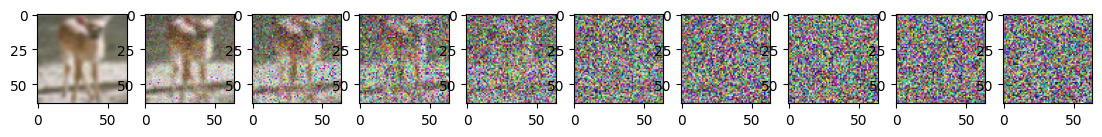

In [19]:
img = next(iter(train_loader))[0]
num_images = 10
stepsize = int(T/num_images)
plt.figure(figsize=(15,15))
plt.axis('off')

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img1, noise = forward_diffusion(img, t)
    display_image(img1)

In [20]:
class Block(nn.Module):
    def __init__(self, in_dim, out_dim, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_dim)
        if up:
            self.conv1 = nn.Conv2d(2*in_dim, out_dim, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_dim, out_dim, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_dim, out_dim, 3, padding=1)
            self.transform = nn.Conv2d(out_dim, out_dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_dim, out_dim, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_dim)
        self.bnorm2 = nn.BatchNorm2d(out_dim)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = self.bnorm2(self.relu(self.conv2(h + time_emb)))
        return self.transform(h)

In [21]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        embeddings = math.log(10000) / ((self.dim // 2) - 1)
        embeddings = torch.exp(torch.arange(self.dim // 2, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [22]:
class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        channels = 3
        d_channels = (64, 128, 256, 512, 1024)
        u_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.conv0 = nn.Conv2d(channels, d_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(d_channels[i], d_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(d_channels)-1)])
        self.ups = nn.ModuleList([Block(u_channels[i], u_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(u_channels)-1)])
        self.output = nn.Conv2d(u_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for d in self.downs:
            residual_inputs.append(d(x, t))
        for u in self.ups:
            residual_x = residual_inputs.pop()
            x = u(torch.cat((x, residual_x), dim=1), t)
        return self.output(x)

model = SimpleUnet()

In [23]:
def get_loss(model, x_0, timestep):
    x_noisy, noise = forward_diffusion(x_0, timestep, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index(betas, t, x.shape)
    alpha_bar2_t = get_index(alpha_bar2, t, x.shape)
    alpha_rec_t = get_index(alpha_rec, t, x.shape)
    model_mean = alpha_rec_t * (x - betas_t * model(x, t) / alpha_bar2_t)
    posterior_variance_t = get_index(posterior_variance, t, x.shape)
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    num_images = 10
    stepsize = int(T/num_images)
    img_size = 64
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            display_image(img.detach().cpu())
    plt.show()

In [ ]:
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 20
loss_model = []

for epoch in range(epochs):
    loss_per_epoch = []
    for step, batch in enumerate(train_loader):
      optimizer.zero_grad()
      batch_size = batch[0].shape[0]
      t = torch.randint(0, T, (batch_size,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss_per_epoch.append(loss.item())
      loss.backward()
      optimizer.step()

      if step % 50 == 0:
          print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
          sample_plot_image()
    loss_model.append(np.mean(loss_per_epoch))

plt.plot(loss_model)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

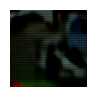

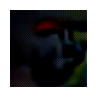

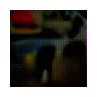

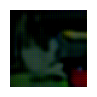

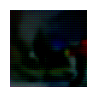

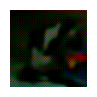

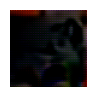

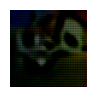

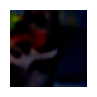

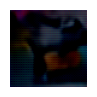

In [31]:
import os
os.makedirs('images', exist_ok=True)
with torch.no_grad():
    for i in range(10):
        img_size = 64
        img = torch.randn((1, 3, img_size, img_size), device=device)
        for t in range(T - 1, -1, -1):
            timestep = torch.full((1,), t, device=device, dtype=torch.long)
            img = sample_timestep(img, timestep)
            img = torch.clamp(img, -1.0, 1.0)
        img_cpu = img.cpu().numpy()

        plt.figure(figsize=(1, 1))
        plt.axis("off")
        plt.imshow(np.transpose(img_cpu[0], (1, 2, 0)))
        plt.show()
        plt.savefig('images/fake_image_%d.png' % i)
        plt.close()

In [33]:
# report inception score on the generated images.
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=1, resize=False, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [34]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = os.listdir(root)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

dataset = CustomImageFolder(root='images', transform=transform)

print("Calculating Inception Score...")
print(inception_score(dataset, cuda=True, batch_size=1, resize=True, splits=10))

Calculating Inception Score...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 147MB/s]
<ipython-input-33-5979f1b452ee>:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  retur

(1.0, 0.0)
